# A simple water segmentation using UNet

This notebook demonstrates how to use UNet for a simple water segmentation

# Install packages

In [1]:
!pip install numpy \
             pandas \
             xarray \
             rioxarray \
             rasterio \
             hydrafloods \
             tensorflow \
             torch \
             scikit-learn \
             scipy \
             geemap \
             earthengine-api \
             restee \
             patchify \
             segmentation_models 

                      

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 104.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 97.8 MB/s eta 0:00:00
  Preparing metada

# Import packages

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import geemap
import ee
import hydrafloods as hf
import restee

import xarray as xr
import rasterio as rio
import rioxarray
from rioxarray.merge import merge_arrays
import numpy as np
import dask.array as da

from patchify import patchify
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy as sci
from scipy import ndimage

import glob
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.path import Path
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import datetime as dt
import urllib.request
import re
import pytz
import os
import gc


_ = geemap.Map()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Z1gMeuz0jktEuU2MY0Ox0Kx_7jSYfJvXReUjiyqjvss&tc=gut8wM9Lw4VI88PKg8-xJ9bDC1l2CE1oHRcgW_PUdi4&cc=CGwbdYi5SrO2c1nBW_kK3Iq4dZ_2dqi626moKe8vLnQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk4A3lP0x7YopsbUVC7xQ4VO8RWrBuHr4s-BiRALbJfUm2b-OgE_N4A

Successfully saved authorization token.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**HYDRAFloods GEE ImageCollection batch_export function seems to have bug**

Correct the bug and paste to here for convenience

In [82]:
import ee
from ee.ee_exception import EEException
import math
import string
import random
import datetime
from hydrafloods import decorators
import hydrafloods.indices as all_indices


def export_image(
    image,
    region,
    asset_id=None,
    description=None,
    scale=1000,
    crs="EPSG:4326",
    pyramiding=None,
    export_type="toAsset",
    folder=None,
):
    """Function to wrap image export with EE Python API

    args:
        image (ee.Image): image to export
        region (ee.Geometry): region to export image
        asset_id (str | None, optional): asset ID to export image to\
            if None then asset_id will be a random string. default = None
        description (str | None, optional): description to identify image export/
            if None then description will be random string. default = None
        scale (int, optional): resolution in meters to export image to. default = 1000
        crs (str, optional): epsg code to export image to. default = "EPSG:4326"
        pyramiding (dict | None, optional): dictionary defining band pyramiding scheme.
            if None then "mean" will be used as default for all bands. default = None
        export_type (str, optional) : method by which to export the image.
            Default is 'toAsset', can also be 'toDrive'.
        folder (str | None, optional): target folder to export for 'toDrive'/
            if None then export should go to root of Drive

    """
    if (asset_id is None) or (type(asset_id) != str):
        asset_id = "".join(
            random.SystemRandom().choice(string.ascii_letters) for _ in range(8)
        ).lower()
    if (description is None) or (type(description) != str):
        description = "".join(
            random.SystemRandom().choice(string.ascii_letters) for _ in range(8)
        ).lower()
    if type(export_type) != str:
        raise TypeError(
            f"Input for export_type not a string, was a " f"{type(export_type)}."
        )
    elif (export_type != "toAsset") and (export_type != "toDrive"):
        raise ValueError(
            "Invalid input for export_type, must be " '"toAsset" or "toDrive".'
        )
    if (folder is not None) and (type(folder) != str):
        raise TypeError(f"Input for folder was not a string, was a " f"{type(folder)}")
    # get serializable geometry for export
    export_region = region.bounds(maxError=10).getInfo()["coordinates"]

    if pyramiding is None:
        pyramiding = {".default": "mean"}

    # set export process
    if export_type == "toAsset":
        export = ee.batch.Export.image.toAsset(
            image,
            description=description,
            assetId=asset_id,
            scale=scale,
            region=export_region,
            maxPixels=1e13,
            crs=crs,
            pyramidingPolicy=pyramiding,
        )
    elif export_type == "toDrive":
        export = ee.batch.Export.image.toDrive(
            image,
            description=description,
            folder=folder,
            scale=scale,
            region=export_region,
            maxPixels=1e13,
            crs=crs,
        )
    # start export process
    export.start()

    return


def batch_export(
    collection,
    collection_asset,
    region=None,
    prefix=None,
    suffix=None,
    scale=1000,
    crs="EPSG:4326",
    pyramiding=None,
    export_type="toAsset",
    folder=None,
    metadata=None,
    verbose=False,
):
    """Function to export each image in a collection
    Wraps `export_image` will set YYYYMMdd formatted time in file name

    args:
        collection (ee.ImageCollection): image collection to export
        collection_asset (str): image collection asset ID to export to
        region (ee.Geometry): region to export image
        prefix (str): prefix string to add before time info in name
        suffix (str): suffix string to add after time info in name
        scale (int, optional): resolution in meters to export image to. default = 1000
        crs (str, optional): epsg code to export image to. default = "EPSG:4326"
        pyramiding (dict | None, optional): dictionary defining band pyramiding scheme.
            if None then "mean" will be used as default for all bands. default = None
        export_type (str, optional) : method by which to export the image.
            Default is 'toAsset', can also be 'toDrive'.
        folder (str | None, optional): target folder to export for 'toDrive'/
                if None then export should go to root of Drive
        metadata (dict | None, optional):
        verbose (bool, optional):

    """
    if type(collection) is not ee.imagecollection.ImageCollection:
        try:
            collection = getattr(collection, "collection")
        except Exception as e:
            raise TypeError(
                "argument collection needs to be either of type ee.ImageCollection "
                "or hydrafloods.hfCollection"
            )

    n = collection.size()
    exportImages = collection.sort("system:time_start", False).toList(n)
    nIter = n.getInfo()

    for i in range(nIter):
        img = ee.Image(exportImages.get(i))
        if metadata is not None:
            img = img.set(metadata)

        t = img.get("system:time_start").getInfo()
        date = datetime.datetime.utcfromtimestamp(t / 1e3).strftime("%Y%m%d")

        if region is None:
            region = img.geometry()

        exportName = date
        if prefix is not None:
            exportName = f"{prefix}_" + exportName
        if suffix is not None:
            exportName = exportName + f"_{suffix}"

        description = exportName
        if verbose:
            print(f"running export for {description}")

        if not collection_asset.endswith("/"):
            collection_asset += "/"

        exportName = collection_asset + description

        export_image(
            img,
            region,
            asset_id=exportName, # originally was "assed_id", should be "asset_id"
            description=description,
            scale=scale,
            crs=crs,
            pyramiding=pyramiding,
            export_type=export_type,
            folder=folder,
        )

    return

# Data preparation using Google Earth Engine (GEE)

**Map function for clipping the GEE ImageCollection**

In [5]:
def clip_aoi(image):
    return image.clip(aoi_bbox)

**1. Define an Area-Of-Interest (AOI)**

In [6]:
# ----- Define AOI as a rectangle (can be polygon as well, check "ee.Geometry.Polygon") -----
xmin = 102.864
xmax = 105.471
ymin = 11.779
ymax = 13.7742 
aoi_bbox = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])

**2. Get Digital Elevation Model**

In [7]:
# ----- Get DEM and calculate its aspect, slope -----
# Use MERIT DEM here, but can be switched to others by changing "dem_src"
# Check GEE Data Catalogue
dem_src = 'MERIT/DEM/v1_0_3'
if dem_src == 'MERIT/DEM/v1_0_3':
    dem_band = 'dem'
else:
    dem_band = 'elevation' # This part has to be changed based on different DEM data

dem_data = ee.Image(dem_src).select(dem_band)

dem_aoi = dem_data.clip(aoi_bbox) #clip the DEM to AOI

# Calculate aspect, slope of DEM
apt_aoi = ee.Terrain.aspect(dem_aoi)
slp_aoi = ee.Terrain.slope(dem_aoi)

**3. Get Sentinel-1 GEE ImageCollection and pre-process it**

In [8]:
# ----- Get the GEE ImageCollection -----
s1_query_col = (ee.ImageCollection("COPERNICUS/S1_GRD")
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VV'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VH'))   
           .filter(ee.Filter.eq('platform_number','A')) # or 'B'
           .filter(ee.Filter.eq('instrumentMode', 'IW'))
           .filter(ee.Filter.eq('relativeOrbitNumber_start',91)) # Can check Alaska Satellite Facility Data Vertex to get the relative orbit number (Path)
           .filter(ee.Filter.eq('relativeOrbitNumber_stop',91))
           .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
           .filter(ee.Filter.date('2016-01-01','2018-12-31'))
           .filter(ee.Filter.bounds(aoi_bbox))
)

# ----- Use HYDRAFloods for satellite image pre-processing (mosaicking, slope correction, speckle filtering) -----
mosaick_opt = 1 # This part depends on if your AOI requires mosaicking frames of images
s1_query_hf = hf.datasets.Dataset.from_imgcollection(s1_query_col) # Convert GEE ImageCollection to HYDRAFloods dataset
if mosaick_opt:
    s1_query_hf = s1_query_hf.aggregate_time(clip_to_area=True) # Mosaic images in the collection by date
s1_query_hf_flat = s1_query_hf.apply_func(hf.slope_correction, elevation = dem_data) # Slope correction      
s1_query_hf_flat_filt = s1_query_hf_flat.apply_func(hf.filtering.gamma_map) # Speckle filtering
s1_query_hf_flat_filt = ee.ImageCollection(s1_query_hf_flat_filt.collection) # Convert HYDRAFloods ImageCollection to GEE ImageCollection
s1_aoi = s1_query_hf_flat_filt.map(clip_aoi) # Clip the GEE ImageCollection to the AOI


**4. Get land cover data**

In [9]:
# ----- Land cover data -----
lulc_data = ee.ImageCollection("ESA/WorldCover/v100").first().select('Map')
lulc_aoi = lulc_data.clip(aoi_bbox)

**5. Get HAND data**

In [10]:
# ----- MERIT-Hydro. It contains the "HAND" model derived from MERIT-DEM -----
hand_data = ee.Image("MERIT/Hydro/v1_0_1").select('hnd')
hand_aoi = hand_data.clip(aoi_bbox)

**6. JRC permanent water**

In [11]:
# ----- Get the JRC permanent water -----
# This is to fill the permanent water where can be bright due to surface roughness change, and is falsly considered as non-water
jrc_gsw = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").select('transition')
jrc_perm_mask = jrc_gsw.eq(1) #.Or(jrc_gsw.eq(8)) 
jrc_permw_aoi = jrc_gsw.updateMask(jrc_perm_mask).clip(aoi_bbox)



**More layers may be added**

**Visualize each layer**

In [12]:
Map_chk_query = geemap.Map(center=((ymin+ymax)/2, (xmin+xmax)/2), zoom=8)
Map_chk_query.addLayer(s1_aoi.select('VV').reduce(ee.Reducer.mean()).select('VV_mean'), {'min':-25, 'max':0, 'palette':['black','white']}, 'Mean_S1_SAR')
Map_chk_query.addLayer(dem_aoi, {'min':0,'max':100,'palette':['black','white']}, 'DEM_slope')
Map_chk_query.addLayer(slp_aoi, {'min':0,'max':0.2,'palette':['black','white']}, 'DEM_slope')
#Map_chk_query.addLayer(apt_aoi, {'min':0,'max':360,'palette':['green','brown','white']}, 'DEM_aspect')
#Map_chk_query.addLayer(lulc_aoi, {'min':0,'max':100,'palette':['blue','white']}, 'LULC')
Map_chk_query.addLayer(hand_aoi, {'min':0,'max':100,'palette':['blue','white']}, 'HAND')
Map_chk_query.addLayer(jrc_permw_aoi,{'min':0,'max':1,'palette':['black','white']},'JRC Perm. Water')
Map_chk_query.addLayer(aoi_bbox, {}, 'AOI_bbox')
Map_chk_query.addLayerControl()
display(Map_chk_query)

Map(center=[12.7766, 104.1675], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

# Export data to G-Drive as GeoTIFF

In [13]:
# ----- (0: Do not export; 1 export) the images
export_s1_opt = 0
export_aux_opt = 0

res=50 # define spatial resolution of the exported GeoTiff
img_prefix = 'TSL'
img_suffix = 'VV'
s1_export_band = 'VV' #'VV' or 'VH'
export_crs = 'EPSG:4326' #Coordinate system of the exported GeoTiff

if export_s1_opt:
    #hf.geeutils.batch_export(s1_aoi.select(s1_export_band), collection_asset = 'UNet_', region=aoi_bbox, prefix=img_prefix, suffix=img_suffix, scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder='UNet_examp_S1_'+str(res).zfill(3)+'m', metadata=None, verbose=False) 
    batch_export(s1_aoi.select(s1_export_band), collection_asset = 'UNet_', region=aoi_bbox, prefix=img_prefix, suffix=img_suffix, scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder='UNet_examp_S1_'+str(res).zfill(3)+'m', metadata=None, verbose=False)
else:
    print('Users requested not to export Sentinel-1 VV intensity')

if export_aux_opt:
    hf.geeutils.export_image(slp_aoi, region=aoi_bbox, asset_id=None, description='slope_'+str(res).zfill(3)+'m', scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder=None) 
    hf.geeutils.export_image(lulc_aoi, region=aoi_bbox, asset_id=None, description='lulc_'+str(res).zfill(3)+'m', scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder=None) 
    hf.geeutils.export_image(hand_aoi, region=aoi_bbox, asset_id=None, description='hand_'+str(res).zfill(3)+'m', scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder=None) 
    hf.geeutils.export_image(jrc_permw_aoi, region=aoi_bbox, asset_id=None, description='jrc_permw_'+str(res).zfill(3)+'m', scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder=None) 
    hf.geeutils.export_image(dem_aoi, region=aoi_bbox, asset_id=None, description='dem_'+str(res).zfill(3)+'m', scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder=None) 
else:
    print('Users requested not to export auxiliar layers')

Users requested not to export Sentinel-1 VV intensity
Users requested not to export auxiliar layers


# Prepare the data

**IMPORTANT: Need to be aware of the standardization and normalization process**

All the input data of the same feature should be standardized/normalized with the same scaling factor and offset. In addition, the new data need to be standardized/normalized with the same scaling factor and offset as well, to make sure the training and predicting input have the same scale

In [14]:
# ----- Define the spatial resolution -----
res = 100

# ----- Path to the data -----
indata_path = '/content/drive/MyDrive/UNet/example/'


# Read slope
in_dem = xr.open_rasterio(indata_path+'dem/dem_'+str(res).zfill(3)+'m.tif').sortby('y',ascending=False).sortby('x',ascending=True).values[0,:,:]

# Read slope
in_slp = xr.open_rasterio(indata_path+'dem/slope_'+str(res).zfill(3)+'m.tif').sortby('y',ascending=False).sortby('x',ascending=True).values[0,:,:]

# Read lulc
in_lulc = xr.open_rasterio(indata_path+'lulc/lulc_'+str(res).zfill(3)+'m.tif').sortby('y',ascending=False).sortby('x',ascending=True).values[0,:,:]

# Read HAND
in_hand = xr.open_rasterio(indata_path+'hand/hand_'+str(res).zfill(3)+'m.tif').sortby('y',ascending=False).sortby('x',ascending=True).values[0,:,:]

# Read JRC Perm water
in_jrc_permw = xr.open_rasterio(indata_path+'jrc/jrc_permw_'+str(res).zfill(3)+'m.tif').sortby('y',ascending=False).sortby('x',ascending=True).values[0,:,:]



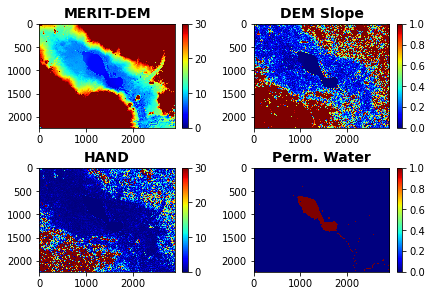

0

In [15]:
fontdict={'size':14, 'weight':'bold'}

fig, axs = plt.subplots(2,2, layout="constrained")
im = axs[0,0].imshow(in_dem, interpolation='none', cmap='jet', vmin=0, vmax=30)
axs[0,0].set_title('MERIT-DEM', fontdict=fontdict)
plt.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(in_slp, interpolation='none', cmap='jet', vmin=0, vmax=1)
axs[0,1].set_title('DEM Slope', fontdict=fontdict)
plt.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(in_hand, interpolation='none', cmap='jet', vmin=0, vmax=30)
axs[1,0].set_title('HAND', fontdict=fontdict)
plt.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(in_jrc_permw, interpolation='none', cmap='jet', vmin=0, vmax=1)
axs[1,1].set_title('Perm. Water', fontdict=fontdict)
plt.colorbar(im, ax=axs[1,1])
plt.show()

gc.collect()
gc.collect()
gc.collect()

In [16]:
# Initialize scaler for different layers
scaler_dem = MinMaxScaler()
scaler_slp = MinMaxScaler()
scaler_lulc = MinMaxScaler()
scaler_hand = MinMaxScaler()

# Normalize different layers to [0,1] range
# Note that sklearn scaler scale the data along axis=0. To scale the entire array, data has to be flattened first
spatial_shape = in_dem.shape
in_dem = scaler_dem.fit_transform(in_dem.reshape(-1,1)).reshape(spatial_shape) # (dem_in - np.nanmin(dem_in))/(np.nanmax(dem_in)-np.nanmin(dem_in))
in_slp = scaler_slp.fit_transform(in_slp.reshape(-1,1)).reshape(spatial_shape) #(slp_in - np.nanmin(slp_in))/(np.nanmax(slp_in)-np.nanmin(slp_in))
in_lulc = scaler_lulc.fit_transform(in_lulc.reshape(-1,1)).reshape(spatial_shape) #(lulc_in - np.nanmin(lulc_in))/(np.nanmax(lulc_in)-np.nanmin(lulc_in))
in_hand = scaler_hand.fit_transform(in_hand.reshape(-1,1)).reshape(spatial_shape) #(hand_in - np.nanmin(hand_in))/(np.nanmax(hand_in)-np.nanmin(hand_in))


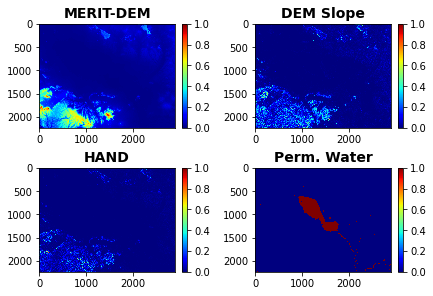

0

In [17]:
fontdict={'size':14, 'weight':'bold'}

fig, axs = plt.subplots(2,2, layout="constrained")
im = axs[0,0].imshow(in_dem, interpolation='none', cmap='jet', vmin=0, vmax=1)
axs[0,0].set_title('MERIT-DEM', fontdict=fontdict)
plt.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(in_slp, interpolation='none', cmap='jet', vmin=0, vmax=1)
axs[0,1].set_title('DEM Slope', fontdict=fontdict)
plt.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(in_hand, interpolation='none', cmap='jet', vmin=0, vmax=1)
axs[1,0].set_title('HAND', fontdict=fontdict)
plt.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(in_jrc_permw, interpolation='none', cmap='jet', vmin=0, vmax=1)
axs[1,1].set_title('Perm. Water', fontdict=fontdict)
plt.colorbar(im, ax=axs[1,1])
plt.show()

gc.collect()
gc.collect()
gc.collect()

In [18]:
# Read pre-processed Sentinel-1 images
s1_data_path = indata_path+'S1/'+str(res).zfill(3)+'m/A/'

# Normalize the data by minimum and maximum. You only need the minimum and maximum of all images of same feature.
s1_flist = glob.glob(s1_data_path+'*.tif')

all_s1_min = 999999
all_s1_max = -999999
for s1_fname in s1_flist:
    in_s1 = xr.open_rasterio(s1_fname).sortby('y',ascending=False).sortby('x',ascending=True).squeeze().drop('band')
    in_s1_max = in_s1.max(dim=['x','y'], skipna=True)
    in_s1_min = in_s1.min(dim=['x','y'], skipna=True)
    if in_s1_max > all_s1_max:
        all_s1_max = in_s1_max
    if in_s1_min < all_s1_min:
        all_s1_min = in_s1_min  
all_s1_max = all_s1_max.values
all_s1_min = all_s1_min.values
print(all_s1_max, all_s1_min)

gc.collect()
gc.collect()
gc.collect()

20.749968 -92.17071


0

In [19]:
# Function to resize the data to be the multiple of patch size
def resize_data(in_img, patch_size):
    size_x = (in_img.shape[1]//patch_size)*patch_size
    size_y = (in_img.shape[0]//patch_size)*patch_size
    out_img = in_img[0:size_y, 0:size_x]
    return out_img

In [20]:
multi_channel_opt = 1

patch_size = 256
dcube_features_temp = []
dcube_labels_temp = []
ct_img = 0

# ----- A simple threshold to generate training label data (binary flood maps) -----
fld_thrd = -16

for s1_fname in s1_flist:
    
    ct_img = ct_img+1
    in_s1 = xr.open_rasterio(s1_fname).sortby('y',ascending=False).sortby('x',ascending=True).squeeze().drop('band')
    if s1_fname == s1_flist[0]:
        lat = in_s1.y
        lon = in_s1.x
    in_s1 = in_s1.values
    
    # As an example, I simply use a general threshold value to get Sentinel-1 flood extents which will be used as training label data (1: water, 0: non-water).
    # Practically, this threshold has to be refined.
    s1_water = np.where(in_s1<fld_thrd, 1, 0)
    s1_water = np.where(np.isnan(in_s1),np.nan,s1_water)
    
    # Resize the image to be the multiple of patch size
    in_s1 = resize_data(in_s1, patch_size)
    in_slp = resize_data(in_slp, patch_size)
    in_lulc = resize_data(in_lulc, patch_size)
    in_dem = resize_data(in_dem, patch_size)
    in_hand = resize_data(in_hand, patch_size)
    in_jrc_permw = resize_data(in_jrc_permw, patch_size)
    s1_water = resize_data(s1_water, patch_size)


    # Normalize S1 images with the pre-calculated min and max values of all training S1 images    
    in_s1 = (in_s1 - all_s1_min)/(all_s1_max - all_s1_min)

    # overlay several channels as features
    if multi_channel_opt:
        in_features = np.concatenate([np.expand_dims(in_s1, axis=-1), np.expand_dims(in_slp, axis=-1)], axis=-1) # Add DEM_Slope
        in_features = np.concatenate([in_features, np.expand_dims(in_hand, axis=-1)], axis=-1)                   # Add HAND
        in_features[np.any(np.isnan(in_features), axis=-1),:]=np.nan
    else:
        in_features = in_s1
    
    # Fill the gappy water extents caused by lake surface roughness on SAR images with JRC perm. water
    s1_water[in_jrc_permw==1] = 1

    # Generate input patches
    patch_features = patchify(in_features, (patch_size,patch_size,in_features.shape[-1]), step=patch_size) # 'step' is the same as 'stride' in convolution
    patch_labels = patchify(s1_water, (patch_size,patch_size), step=patch_size)
    
    del in_features, s1_water
    gc.collect()

    # Pile up patches
    for i in np.arange(patch_features.shape[0]):
        for j in np.arange(patch_features.shape[1]):
            if multi_channel_opt:
                single_patch_features = patch_features[i,j,:,:][0]
            else:
                single_patch_features = patch_features[i,j,:,:]
            single_patch_labels = patch_labels[i,j,:,:]
          
            dcube_features_temp.append(single_patch_features)
            dcube_labels_temp.append(single_patch_labels)
print(ct_img)
gc.collect()

# Reshape the piled-up data to be a data cube (patch, X, Y)
dcube_features_temp = np.array(dcube_features_temp)
dcube_labels_temp = np.array(dcube_labels_temp)


# Check if piled data cube has correct dimension
if ((lat.shape[0]//patch_size)*(lon.shape[0]//patch_size)*len(s1_flist) == dcube_features_temp.shape[0]):
    print('Data cube dimension is correct. You can proceed')
    del patch_features, patch_labels, single_patch_features, single_patch_labels
    gc.collect()     
    gc.collect()
else:
    print('Data cube dimension is wrong, please carefully check your data first')


78
Data cube dimension is correct. You can proceed


In [21]:
# Patch refinement
# - Only retain patches that have no NaN pixels, and patches with inundated pixels > 10%
slice_retain = []
for k in np.arange(dcube_labels_temp.shape[0]):
    if np.count_nonzero(np.isnan(dcube_labels_temp[k]))==0 and np.count_nonzero(dcube_labels_temp[k])*100/(patch_size**2) > 30:
        slice_retain.append(k)        
slice_retain = np.array(slice_retain)

image_dataset = dcube_features_temp[slice_retain]
mask_dataset = dcube_labels_temp[slice_retain]

del dcube_features_temp, dcube_labels_temp
gc.collect()

0

In [22]:
# Check data size
image_dataset.shape, mask_dataset.shape

((520, 256, 256, 3), (520, 256, 256))

# Patch: 35


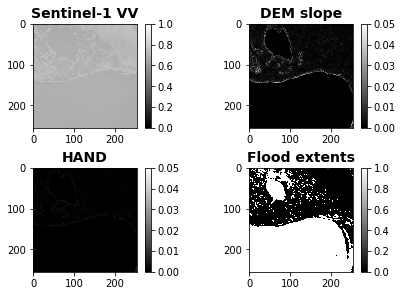

In [23]:
# Inspect if patches look reasonable
import random

fontdict={'size':14, 'weight':'bold'}

npatch = random.randint(0, len(image_dataset)-1)
print('# Patch:', npatch)

fig, axs = plt.subplots(2, 2, layout='constrained')
im = axs[0,0].imshow(image_dataset[npatch][:,:,0], interpolation='none', vmin=0, vmax=1, cmap='gray')
axs[0,0].set_title('Sentinel-1 VV', fontdict=fontdict)
fig.colorbar(im, ax=axs[0,0])
im = axs[0,1].imshow(image_dataset[npatch][:,:,1], interpolation='none', vmin=0, vmax=.05, cmap='gray')
axs[0,1].set_title('DEM slope', fontdict=fontdict)
fig.colorbar(im, ax=axs[1,0])
im = axs[1,0].imshow(image_dataset[npatch][:,:,2], interpolation='none', vmin=0, vmax=.05, cmap='gray')
axs[1,0].set_title('HAND', fontdict=fontdict)
fig.colorbar(im, ax=axs[0,1])
im = axs[1,1].imshow(mask_dataset[npatch][:,:], interpolation='none', vmin=0, vmax=1, cmap='gray')
axs[1,1].set_title('Flood extents', fontdict=fontdict)
fig.colorbar(im, ax=axs[1,1])
plt.show()

In [24]:
mask_dataset.shape

(520, 256, 256)

**Split data into training and test sets**

In [32]:
from keras.utils import to_categorical
# Create an array with 'class' as the last dimension based on the label data
# For example, for the case of binary label, the output will have dimension: (patch_size, patch_size, n_classes)
# [x, y, :] = [1,0] or [0,1]

from sklearn.model_selection import train_test_split


# Get training and test data ready
if multi_channel_opt:
    features = image_dataset
else:
    features = np.expand_dims(image_dataset, axis=3)
labels = mask_dataset

n_classes = 1 # Binary segmentation
if n_classes==1:
    labels_cat = np.expand_dims(labels, axis=3)
else:
    labels_cat = to_categorical(labels, num_classes=n_classes)    

# Set 80% of data as training data; 20% of data as test data
x_train, x_test, y_train, y_test = train_test_split(features, labels_cat, test_size = 0.20, random_state = 42)


In [33]:
x_train.shape

(416, 256, 256, 3)

**Data augmentation by flipping the training set**

In [34]:
data_aug_opt=1
if data_aug_opt:

    # Vertically flip the features and labels
    Vx = [np.flip(x, axis=0) for x in x_train]
    Vy = [np.flip(x, axis=0) for x in y_train]

    ## Horizontally flip the features and labels
    Hx = [np.flip(x, axis=1) for x in x_train]
    Hy = [np.flip(x, axis=1) for x in y_train]

    ## Horizontally and Vertically flip the features and labels
    #HVx = [np.flip(x, axis=1) for x in Vx]
    #HVy = [np.flip(x, axis=1) for x in Vy]

    ## Append the flipped images and masks to the original training data
    x_train = np.append(x_train, Vx, axis=0)
    y_train = np.append(y_train, Vy, axis=0)

    x_train = np.append(x_train, Hx, axis=0)
    y_train = np.append(y_train, Hy, axis=0)

    #x_train = np.append(x_train, HVx, axis=0)
    #y_train = np.append(y_train, HVy, axis=0)

In [35]:
x_train.shape, y_train.shape

((1248, 256, 256, 3), (1248, 256, 256, 1))

# Construct the UNet


**Import TensorFlow for machine learning**

In [36]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# ----- Check if GPU exists -----
print(tf.test.gpu_device_name())
device_lib.list_local_devices()

/device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7646536987286710312
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40154759168
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11348164735033110148
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

**Define the UNet model**



In [37]:
# Define the model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from keras.optimizers import Adam

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, kernel_initializer='he_normal', padding='same')(input)
    x = BatchNormalization()(x)
    #x = Dropout(0.2)(x) 
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, 3, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.2)(x) 
    x = Activation('relu')(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


################################################################
def simple_unet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    #Build the model

    if n_classes==1:
        out_act_func = 'sigmoid' 
    else:
        out_act_func = 'softmax'

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Contraction path
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    #Bridge
    b1 = conv_block(p4, 1024)   
    
    #Expansive path 
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
     
    outputs = Conv2D(n_classes, 1, padding='same', activation=out_act_func)(d4)
     
    model = Model(inputs=[inputs], outputs=[outputs], name='U-Net')  
    
    return model
 

In [33]:
gc.collect()

0

**Train the UNet model**

In [38]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# ----- Set up early stopping -----
callback = EarlyStopping(monitor='val_loss', patience=10)


In [39]:
from keras import backend
from keras.metrics import MeanIoU

backend.clear_session()

# ----- Get the dimension of training data -----
IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]

# ----- Define and compile the model -----
model = simple_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
if n_classes==1:  
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy',  metrics=['accuracy'])
else:
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ----- Assign output model name -----
out_model_name = '/content/drive/MyDrive/UNet/example/trained_unet_'+str(res).zfill(3)+'m_ch'+str(IMG_CHANNELS).zfill(2)+'.hdf5'
history1 = model.fit(x_train, y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=1000, 
                    validation_data=(x_test, y_test),
                    callbacks=[callback, ModelCheckpoint(filepath=out_model_name, monitor='val_loss', save_best_only=True)], 
                    shuffle=False)


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [40]:
# ----- To completely free the GPU RAM -----
from numba import cuda
free_gpu_ram_opt=0

if free_gpu_ram_opt:
    device = cuda.get_current_device()
    device.reset()

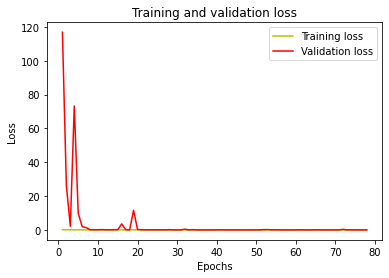

In [41]:
# Check training progress
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Load the trained UNet and do the prediction

In [42]:
# Load the trained model and do the prediction
from keras.models import load_model
from keras.metrics import MeanIoU

load_mdl_opt = 0
if load_mdl_opt:
    model = load_model(out_model_name)  


#Perform prediction and use build-in keras function to calculate IoU
if n_classes==1:
    n_classes_pred = 2 
    y_pred_label = (model.predict(x_test))>0.5
else:
    n_classes_pred = n_classes
    y_pred_label = np.argmax(model.predict(x_test), axis=-1)
    
IOU_keras = MeanIoU(num_classes=n_classes_pred)  
IOU_keras.update_state(y_pred_label, y_test)
print("Mean IoU =", IOU_keras.result().numpy())



4/4 [==============================] - 1s 73ms/step
Mean IoU = 0.9912276


1/1 [==============================] - 0s 27ms/step


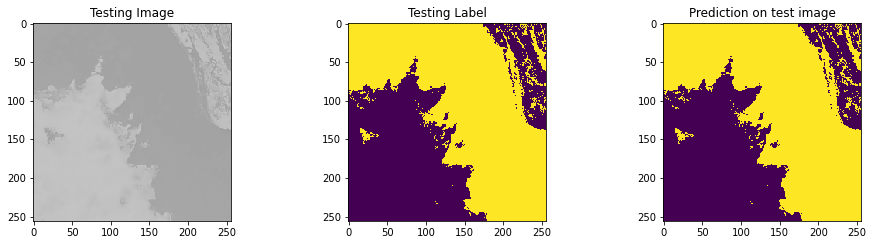

In [53]:
# Check prediction
#Predict on a few images

import random
test_img_number = random.randint(0, len(x_test))
test_img = x_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0]>0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], interpolation='none', cmap='gray', vmin=0, vmax=1)

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], interpolation='none')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, interpolation='none')
plt.show()


# Process independent new Sentinel-1 images as inputs to generate flood extents

In [78]:
# ----- Get the GEE ImageCollection -----
new_s1_query_col = (ee.ImageCollection("COPERNICUS/S1_GRD")
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VV'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VH'))   
           .filter(ee.Filter.eq('platform_number','A')) # or 'B'
           .filter(ee.Filter.eq('instrumentMode', 'IW'))
           .filter(ee.Filter.eq('relativeOrbitNumber_start',91)) # Can check Alaska Satellite Facility Data Vertex to get the relative orbit number (Path)
           .filter(ee.Filter.eq('relativeOrbitNumber_stop',91))
           .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
           .filter(ee.Filter.date('2022-01-01','2022-12-31'))
           .filter(ee.Filter.bounds(aoi_bbox))
)
# ----- Remove problematic image -----
new_s1_query_col = new_s1_query_col.filter(ee.Filter.date('2022-12-15','2022-12-17').Not())

# ----- Use HYDRAFloods for satellite image pre-processing (mosaicking, slope correction, speckle filtering) -----
mosaick_opt = 1 # This part depends on if your AOI requires mosaicking frames of images
new_s1_query_hf = hf.datasets.Dataset.from_imgcollection(new_s1_query_col) # Convert GEE ImageCollection to HYDRAFloods dataset
if mosaick_opt:
    new_s1_query_hf = new_s1_query_hf.aggregate_time(clip_to_area=True) # Mosaic images in the collection by date
new_s1_query_hf_flat = new_s1_query_hf.apply_func(hf.slope_correction, elevation = dem_data) # Slope correction      
new_s1_query_hf_flat_filt = new_s1_query_hf_flat.apply_func(hf.filtering.gamma_map) # Speckle filtering
new_s1_query_hf_flat_filt = ee.ImageCollection(new_s1_query_hf_flat_filt.collection) # Convert HYDRAFloods ImageCollection to GEE ImageCollection
new_s1_aoi = new_s1_query_hf_flat_filt.map(clip_aoi) # Clip the GEE ImageCollection to the AOI


In [83]:
# ----- (0: Do not export; 1 export) the images
export_s1_opt = 0

#res=100 # define spatial resolution of the exported GeoTiff
img_prefix = 'TSL'
img_suffix = 'VV'
s1_export_band = 'VV' #'VV' or 'VH'
export_crs = 'EPSG:4326' #Coordinate system of the exported GeoTiff

if export_s1_opt:
    #hf.geeutils.batch_export(new_s1_aoi.select(s1_export_band), collection_asset = 'UNet_', region=aoi_bbox, prefix=img_prefix, suffix=img_suffix, scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder='UNet_examp_S1_'+str(res).zfill(3)+'m', metadata=None, verbose=False) 
    batch_export(new_s1_aoi.select(s1_export_band), collection_asset = 'UNet_', region=aoi_bbox, prefix=img_prefix, suffix=img_suffix, scale=res, crs=export_crs, pyramiding=None, export_type='toDrive', folder='UNet_examp_S1_'+str(res).zfill(3)+'m', metadata=None, verbose=False) 

else:
    print('Users requested not to export Sentinel-1 VV intensity')


In [140]:
new_s1_water.shape

(2048, 2816)

**Prepare independent input dataset to be put into the trained UNet**

In [185]:
# Read pre-processed Sentinel-1 images
new_s1_data_path = indata_path+'S1/'+str(res).zfill(3)+'m/A_independent/*.tif'

# Normalize the data by minimum and maximum. You only need the minimum and maximum of all images of same feature.
new_s1_flist = glob.glob(new_s1_data_path+'*.tif')
new_s1_flist = glob.glob(new_s1_data_path)

new_dcube_features_temp = []
new_dcube_labels_temp = []
ct_img = 0
date_str = []
for s1_fname in new_s1_flist:
    
    ct_img = ct_img+1
    new_in_s1 = xr.open_rasterio(s1_fname).sortby('y',ascending=False).sortby('x',ascending=True).squeeze().drop('band')
    if s1_fname == new_s1_flist[0]:
        lat = new_in_s1.y
        lon = new_in_s1.x
    new_in_s1 = new_in_s1.values
    date_str.append(s1_fname[-15:-7])
    
    # As an example, I simply use a general threshold value to get Sentinel-1 flood extents which will be used as training label data (1: water, 0: non-water).
    # Practically, this threshold has to be refined.
    new_s1_water = np.where(new_in_s1<fld_thrd, 1, 0)
    new_s1_water = np.where(np.isnan(new_in_s1), np.nan, new_s1_water)
    
    # Resize the image to be the multiple of patch size
    new_in_s1 = resize_data(new_in_s1, patch_size)
    # in_slp = resize_data(in_slp, patch_size)
    # in_lulc = resize_data(in_lulc, patch_size)
    # in_dem = resize_data(in_dem, patch_size)
    # in_hand = resize_data(in_hand, patch_size)
    # in_jrc_permw = resize_data(in_jrc_permw, patch_size)
    new_s1_water = resize_data(new_s1_water, patch_size)
    # Fill the gappy water extents caused by lake surface roughness on SAR images with JRC perm. water
    new_s1_water[in_jrc_permw==1] = 1    
        
    if s1_fname == new_s1_flist[0]:
        new_in_s1_stack = np.expand_dims(new_in_s1, axis=0)
        new_s1_water_stack = np.expand_dims(new_s1_water, axis=0)
    else:
        new_in_s1_stack = np.concatenate((new_in_s1_stack, np.expand_dims(new_in_s1, axis=0)), axis=0)
        new_s1_water_stack = np.concatenate((new_s1_water_stack, np.expand_dims(new_s1_water, axis=0)), axis=0)


    # Normalize S1 images with the pre-calculated min and max values of all training S1 images    
    new_in_s1 = (new_in_s1 - all_s1_min)/(all_s1_max - all_s1_min)

    # overlay several channels as features
    if multi_channel_opt:
        in_features = np.concatenate([np.expand_dims(new_in_s1, axis=-1), np.expand_dims(in_slp, axis=-1)], axis=-1) # Add DEM_Slope
        in_features = np.concatenate([in_features, np.expand_dims(in_hand, axis=-1)], axis=-1)                   # Add HAND
        in_features[np.any(np.isnan(in_features), axis=-1),:]=np.nan
    else:
        in_features = new_in_s1

    # Generate input patches
    patch_features = patchify(in_features, (patch_size, patch_size, in_features.shape[-1]), step=patch_size) # 'step' is the same as 'stride' in convolution
    #patch_labels = patchify(new_s1_water, (patch_size, patch_size), step=patch_size)
    
    del in_features, new_s1_water
    gc.collect()

    # Pile up patches
    for i in np.arange(patch_features.shape[0]):
        for j in np.arange(patch_features.shape[1]):
            if multi_channel_opt:
                single_patch_features = patch_features[i,j,:,:][0]
            else:
                single_patch_features = patch_features[i,j,:,:]
            #single_patch_labels = patch_labels[i,j,:,:]
          
            new_dcube_features_temp.append(single_patch_features)
            #new_dcube_labels_temp.append(single_patch_labels)
print(ct_img)
gc.collect()

# Reshape the piled-up data to be a data cube (patch, X, Y)
new_dcube_features_temp = np.array(new_dcube_features_temp)
#new_dcube_labels_temp = np.array(new_dcube_labels_temp)


# Check if piled data cube has correct dimension
if ((lat.shape[0]//patch_size)*(lon.shape[0]//patch_size)*len(new_s1_flist) == new_dcube_features_temp.shape[0]):
    print('Data cube dimension is correct. You can proceed')
    del patch_features, single_patch_features #, patch_labels, single_patch_labels
    gc.collect()     
    gc.collect()
else:
    print('Data cube dimension is wrong, please carefully check your data first')


29
Data cube dimension is correct. You can proceed


In [144]:
if multi_channel_opt:
    new_features = new_dcube_features_temp
else:
    new_features = np.expand_dims(new_dcube_features_temp, axis=3)
del new_dcube_features_temp
new_features.shape


(2552, 256, 256, 3)

In [129]:
if n_classes==1:
    new_patch_pred = ((model.predict(new_features))>0.5)[:,:,:,0]
else:
    new_patch_pred = np.argmax(model.predict(new_features), axis=-1)
new_pred = np.empty((len(new_s1_flist), new_in_s1.shape[0], new_in_s1.shape[1]))

ct_patch=0
for ct_time in np.arange(len(new_s1_flist)):
    for ct_patch_y in np.arange( new_in_s1.shape[0] / patch_size):
        for ct_patch_x in np.arange( new_in_s1.shape[1] / patch_size):      
            new_pred[ct_time, int(ct_patch_y*patch_size):int((ct_patch_y+1)*patch_size), int(ct_patch_x*patch_size):int((ct_patch_x+1)*patch_size)] = new_patch_pred[ct_patch][:]
            ct_patch = ct_patch+1

# Remove out-of-frame pixels
new_pred = np.where(np.isnan(new_in_s1), np.nan, new_pred)


80/80 [==============================] - 5s 66ms/step


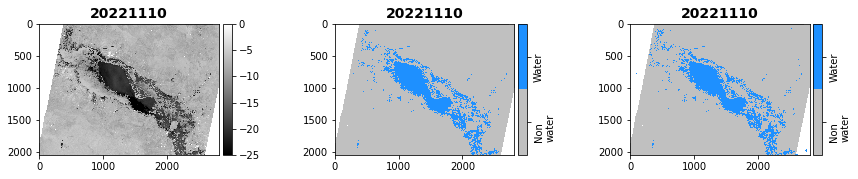

In [188]:
from scipy.sparse import rand
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


indx_img = random.randint(0, len(new_s1_flist)-1)

water_cmap = ListedColormap(['silver','dodgerblue'])
fig, axs = plt.subplots(1,3, layout='constrained', figsize=(15, 15))
im = axs[0].imshow(new_in_s1_stack[indx_img], interpolation='none', cmap='gray', vmin=-25, vmax=0)
axs[0].set_title(date_str[indx_img], fontdict=fontdict)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, ax=axs[0], cax=cax)

im = axs[1].imshow(new_pred[indx_img], interpolation='none', cmap=water_cmap, vmin=-0.5, vmax=1.5)
axs[1].set_title(date_str[indx_img], fontdict=fontdict)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, ax=axs[1], cax=cax)
cbar.set_ticks([0,1])
cbar.set_ticklabels(['Non\nwater','Water'], rotation='vertical')

im = axs[2].imshow(new_s1_water_stack[indx_img], interpolation='none', cmap=water_cmap, vmin=-0.5, vmax=1.5)
axs[2].set_title(date_str[indx_img], fontdict=fontdict)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, ax=axs[2], cax=cax)
cbar.set_ticks([0,1])
cbar.set_ticklabels(['Non\nwater','Water'], rotation='vertical')

box = axs[0].get_position()
box.x0 = box.x0 + 0.05
#box.x1 = box.x1 + 0.05
axs[0].set_position(box)

box1 = axs[1].get_position()
box1.x0 = box1.x0 + 0.05
#box1.x1 = box1.x1 + 0.05
axs[1].set_position(box1)

box2 = axs[2].get_position()
box2.x0 = box2.x0 + 0.05
#box2.x1 = box2.x1 + 0.05
axs[2].set_position(box2)

plt.show()